In [106]:
import numpy as np
import pathlib
import pandas as pd

def get_mat(list_of_dics):
    max_x, max_y = 0, 0
    list_of_ends = []
    for dic in list_of_dics:
        list_of_ends.append(dic.reshape((1,))[0].pop((-1, 0), 0))
        max_x = np.max([max_x, np.max(np.array(list(dic.reshape((1,))[0].keys()))[:, 0], axis=0)])
        max_y = np.max([max_y, np.max(np.array(list(dic.reshape((1,))[0].keys()))[:, 1], axis=0)])
    mats = [np.zeros((max_x+1, max_y+1)) for _ in list_of_dics]
    charges = [0 for _ in list_of_dics]
    for i, (dic, end) in enumerate(zip(list_of_dics, list_of_ends)):
        for key, val in dic.reshape((1,))[0].items():
            mats[i][key] = val
        charges[i] = np.sum(np.real(end))
    return np.array(mats), np.array(charges)

all_arrs = {str(x.stem):get_mat(np.load(str(x), allow_pickle=True)) for x in pathlib.Path('../').glob('**/*get_measurement_record*.npy') if not str(x.stem).startswith('file')}
arrs = np.array([x[1][0] for x in sorted([(float(x.split(',')[0]), y) for x, y in all_arrs.items()])])
charges = -np.array([x[1][1] for x in sorted([(float(x.split(',')[0]), y) for x, y in all_arrs.items()])])
ps = np.array([x[0] for x in sorted([(float(x.split(',')[0]), y) for x, y in all_arrs.items()])])

def mask_arrs(arrs):
    min_p = np.min(ps)
    masked_arrs = []
    for p, arr in zip(ps, arrs):
        del_prob = 1-min_p/p
        masking_arr = np.random.choice([0, 1], size=(len(arr), 79, 40), p=[del_prob, 1-del_prob])
        masked_arr = masking_arr*arr
        masked_arrs.append(masked_arr)
    return np.array(masked_arrs)

masked_arrs = mask_arrs(arrs)[:, :, 40:, :]

## Charges

In [107]:
c = pd.DataFrame(charges).T
c = c.rename(lambda i:ps[i], axis=1)

In [108]:
c.describe()

,0.1,0.3,0.6
count,2000.000000,2000.000000,2000.00000
mean,-0.398000,-0.046000,-0.03200
std,8.246429,7.810274,6.47487
min,-32.000000,-24.000000,-20.00000
25%,-6.000000,-6.000000,-4.00000
50%,0.000000,0.000000,0.00000
75%,6.000000,6.000000,4.00000
max,24.000000,24.000000,22.00000


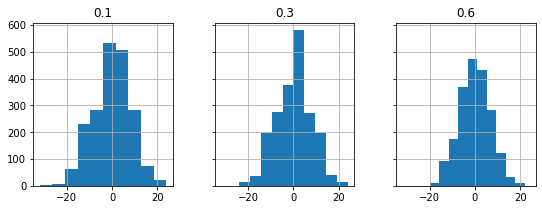

In [109]:
c.hist(layout=(1, 3), sharey=True, sharex=True, figsize=(9, 3));

## Measurement records

In [110]:
summed=pd.DataFrame(np.sum(np.sum(masked_arrs, axis=2), axis=2).T)
summed = summed.rename(lambda i:ps[i], axis=1)
summed.describe()

,0.1,0.3,0.6
count,2000.00000,2000.000000,2000.000000
mean,-1.21000,-0.558000,-0.224500
std,27.66535,27.972287,26.766833
min,-88.00000,-103.000000,-86.000000
25%,-20.00000,-20.000000,-18.000000
50%,-1.00000,0.000000,0.000000
75%,18.00000,18.000000,18.000000
max,83.00000,85.000000,95.000000


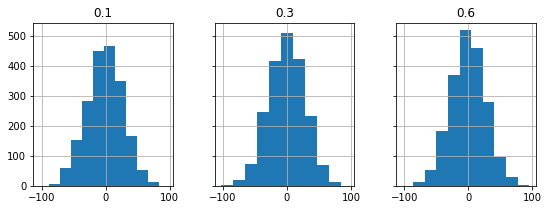

In [111]:
summed.hist(layout=(1, 3), sharey=True, sharex=True, figsize=(9, 3));

## Correlation between (masked) sum of all measurement outcomes, and final charge estimate
 - True in both phases

In [112]:
corr = pd.DataFrame([summed[0.6], c[0.6]]).T
corr.columns = 'sum_of_outcomes', 'charges'

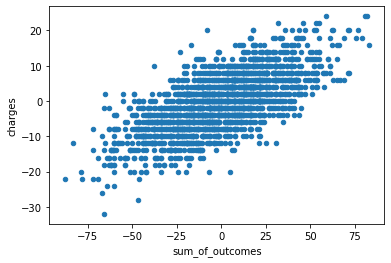

In [116]:
corr.plot.scatter('sum_of_outcomes', 'charges');

In [117]:
corr = pd.DataFrame([summed[0.1], c[0.1]]).T
corr.columns = 'sum_of_outcomes', 'charges'

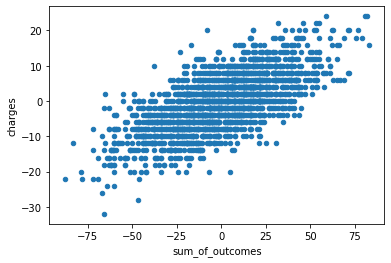

In [118]:
corr.plot.scatter('sum_of_outcomes', 'charges');

## Spatio-temporal

In [127]:
sharp_charges = c[0.6]
sharp_arrs = pd.DataFrame(masked_arrs[-1].reshape(2000, -1))

In [130]:
sharp_arrs

,0,1,2,3,4,5,6,7,8,9,...,1550,1551,1552,1553,1554,1555,1556,1557,1558,1559
0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,...,0.0,-1.0,0.0,-0.0,0.0,-1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,-0.0,0.0,1.0
2,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.0,0.0,1.0,1.0,1.0,0.0
3,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-0.0,1.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.0,0.0,-0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,0.0,...,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,...,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0
1998,-0.0,-1.0,0.0,0.0,-0.0,0.0,1.0,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-1.0


In [132]:
40*79/2

1580.0